In [46]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from skimage.feature import hog
%matplotlib inline

In [89]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Get hog features
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=True,
                     feature_vec=True):
    """
    Function accepts params and returns HOG features (optionally flattened) and an optional matrix for 
    visualization. Features will always be the first return (flattened if feature_vector= True).
    A visualization matrix will be the second return if visualize = True.
    """
    return_list = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),
                                  block_norm= 'L2-Hys', transform_sqrt=False, 
                                  visualise= vis, feature_vector= feature_vec)
    # name returns explicitly
    hog_features = return_list[0]
    if vis:
        hog_image = return_list[1]
        return hog_features, hog_image
    else:
        return hog_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB', include_spatial=True, spatial_size=(32, 32),
                     include_hist=True, hist_bins=32, hist_range=(0, 256),
                     include_hog=True, orient=11, pix_per_cell=8, cell_per_block=3, feature_vec=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        img_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else:
            feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        if include_spatial:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            img_features.append(spatial_features)
        # Apply color_hist() also with a color space option now
        if include_hist:
            hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
            img_features.append(hist_features)
        # include hog features
        if include_hog:
            hog_features, hog_img = get_hog_features(feature_image[:,:,0], orient, pix_per_cell, cell_per_block,
                                            vis=True, feature_vec=feature_vec)
            img_features.append(hog_features)
        #print(spatial_features.shape, hist_features.shape, hog_features[0].shape)
        # Append the new feature vector to the features list
        features.append(np.concatenate(img_features))
    # Return list of feature vectors
    return features


In [93]:
# Read in car and non-car images
car_images = glob.glob('./train/vss/cars1/*.jpeg')
notcar_images = glob.glob('./train/nvs/notcars2/*.jpeg')
cars = []
notcars = []
for image in car_images:
        cars.append(image)
for image in notcar_images:
        notcars.append(image)

# TODO play with these values to see how your classifier
# performs under different binning scenarios
spatial = 16
histbin = 32
color_space = 'LUV'
orient = 11
pix_per_cell = 8
cell_per_block=3
t0=time.time()
car_features = extract_features(cars, cspace='LUV', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256),include_hog=True,
                        orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, feature_vec=True)
notcar_features = extract_features(notcars, cspace='LUV', spatial_size=(spatial, spatial),
                        hist_bins=histbin, hist_range=(0, 256),include_hog=True,
                        orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, feature_vec=True)
t1=time.time()
print(round(t1-t0, 2), 'Seconds to extract features')
print(len(car_features), len(notcar_features))
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
#rand_state = np.random.randint(0, 100)
print(len(X), len(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)#, random_state=rand_state)
    
# Fit a per-column scaler only on the training data
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X_train and X_test
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = len(y_test)
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

17.92 Seconds to extract features
400 400
800 800
Using spatial binning of: 16 and 32 histogram bins
Feature vector length: 4428
0.16 Seconds to train SVC...
Test Accuracy of SVC =  1.0
My SVC predicts:  [1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0.
 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1.
 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 1.
 1. 0. 1. 0. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 1.
 0. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 1. 0. 0.
 1. 1. 1. 0. 0. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 1.]
For these 160 labels:  [1. 0. 1. 1. 0. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0.
 1. 1. 0. 1. 0. 0. 0. 0. 1. 0. 1. 0. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1.
 0. 0. 1. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1.
 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 0.

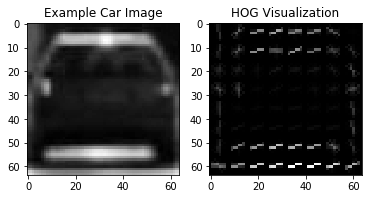

In [91]:
orient = 11
pix_per_cell = 8
cell_per_block=3

img = cv2.imread(cars[1])
img = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
features, hog_image = get_hog_features(img[:,:,0], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(img[:,:,0], cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

In [92]:
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def get_windows(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] is None:
        x_start_stop = [0, img.shape[1]]
    if y_start_stop[0] is None:
        y_start_stop = [img.shape[0]//2, img.shape[0]]
    # Compute the span of the region to be searched
    # Compute the number of pixels per step in x/y
    pxp_xstep = xy_window[0]*(1-xy_overlap[0])
    pxp_ystep = xy_window[1]*(1-xy_overlap[1])
    # Compute total number of windows in x and y
    x_steps = int(( (x_start_stop[1] - x_start_stop[0]) / pxp_xstep ) - 1)
    y_steps = int(( (y_start_stop[1] - y_start_stop[0]) / pxp_ystep ) - 1)
    # Compute the number of windows in x/y
    totat_windows = x_steps*y_steps
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    #     Note: you could vectorize this step, but in practice
    #     you'll be considering windows one by one with your
    #     classifier, so looping makes sense
        # Calculate each window position
        # Append window position to list
    cy = y_start_stop[0]
    for y in range(y_steps):
        cx = x_start_stop[0]
        for x in range(x_steps):
            top_left = (int(cx), int(cy))
            bottom_right = (int(cx + xy_window[0]), int(cy + xy_window[1]))
            window_list.append((top_left, bottom_right))
            cx += pxp_xstep
        cy += pxp_ystep
    # Return the list of windows
    return window_list

In [ ]:
# get hog features for all image channels
def get_hog_feature_all_channels(img, orient, pix_per_cell, cell_per_block, scale=1):
    ch1 = img[:,:,0]
    ch2 = img[:,:,1]
    ch3 = img[:,:,2]
    hf_ch1, tmp = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hf_ch2, tmp = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hf_ch3, tmp = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    return hf_ch1, hf_ch2, hf_ch3

# get features to use or prediction for each window
# hog_meta is a dictionary containing params: orient, pix_per_cell, pix_per_block
def get_features_for_window(img, window, hog_features, hog_meta, inc_spatial, inc_hist):
    # hog cell details
    pix_per_cell = hog_meta.pix_per_cell
    cell_per_block = hog_meta.cell_per_block
    # multi-window sizes, multiples of hog cell size to ease custom feature extraction
    win_sizes = [128, 64, 32, 16]
    # y-axis scan range
    y_fullrange_img = [img.shape[0]//2, img.shape[0]-50]
    y_len = y_fullrange_img[1] - y_fullrange_img[0]
    # range_offsets along x-axis for each window
    x_offset = [0, img.shape[1]//32, img.shape[1]//16, img.shape[1]//4]
    # range_offsets along y-axis for each window
    y_offset = [0, y_len//16, y_len//8, y_len//4]
    '''all_windows = {128: [None],
              64: [None],
              32: [None],
              16: [None]}'''
    all_windows = []
    # find hot boxes for each window size
    for i in win_sizes:
        # scan range for y-axis
        y_range_img = [y_fullrange_img[0] + y_offset[i], y_fullrange_img[1] - y_offset[i]]
        # get x range for search
        x_range_img = [x_offset[i], image.shape[1] - x_offset[i]]
        # get all the windows in this range
        all_windows.append(get_windows(img, x_start_stop=x_range_img, y_start_stop=y_range_img, 
                                        xy_window=(win_sizes[i], win_sizes[i]), xy_overlap=(0.75, 0.75)))
    ##### find features for all the windows
    features = []
    spatial_size = (32, 32)
    hist_bins = 32
    hist_range = (0, 256)
    hog_f1 = hog_features[0]
    hog_f2 = hog_features[1]
    hog_f3 = hog_features[2]
    hog_blocks_x = img.shape[1]//(hog_f1.shape[0]+1)
    # loop over windows to get features for
    for win in all_windows:
        win_features = []
        # image patch for which to get features
        tlt, brt = win
        img_win = img[tlt[1]:brt[1]+1, tlt[0]:brt[0]+1]
        # get spatial features
        if inc_spatial:
            spf = bin_spatial(img_win, size=spatial_size)
            win_features.append(spf)
        # get color histogram features
        if inc_hist:
            hsf = color_hist(img_win, nbins=hist_bins, bins_range=hist_range)
            win_features.append(hsf)
        # get hog features
        hxs = (tlt[0]//pix_per_cell) + 1    #cell no. equals block no.
        hys = (tlt[1]//pix_per_cell) + 1
        hxe = ((brt[0] - tlt[0])//pix_per_cell) - 1    #total blocks in window range
        hye = ((brt[1] - tlt[1])//pix_per_cell) - 1
        hog_ch1 = hog_f1[hys:hye+1, hxs:hxe+1]
        hog_ch2 = hog_f2[hys:hye+1, hxs:hxe+1]
        hog_ch3 = hog_f3[hys:hye+1, hxs:hxe+1]
        hgf = np.hstack((hog_ch1, hog_ch2, hog_ch3))
        win_features.append(hgf)
        features.append(win_features)
    # return the accumulated features
    return features

def get_heatmap():
    pass

def find_cars(img):
    # crop the image and get relevant image portion for scanning
    # hog cell details
    pix_per_cell = hog_meta.pix_per_cell
    cell_per_block = hog_meta.cell_per_block
    # multi-window sizes, multiples of hog cell size to ease custom feature extraction
    win_sizes = [128, 64, 32, 16]
    # y-axis scan range
    y_fullrange_img = [img.shape[0]//2, img.shape[0]-50]
    y_len = y_fullrange_img[1] - y_fullrange_img[0]
    # range_offsets along x-axis for each window
    x_offset = [0, img.shape[1]//32, img.shape[1]//16, img.shape[1]//4]
    # range_offsets along y-axis for each window
    y_offset = [0, y_len//16, y_len//8, y_len//4]
    # list of windows for each window size
    all_windows = {128: [],
                  64: [],
                  32: [],
                  16: []}
    overlap = 0.75
    #all_windows = []
    # find boxes and hog features for entire area to be scanned for each window size
    for i in win_sizes:
        # scan range for y-axis
        y_range_img = [y_fullrange_img[0] + y_offset[i], y_fullrange_img[1] - y_offset[i]]
        # get x range for search
        x_range_img = [x_offset[i], image.shape[1] - x_offset[i]]
        # get all the windows in this range
        all_windows[win_sizes[i]] = get_windows(img, x_start_stop=x_range_img, y_start_stop=y_range_img, 
                                        xy_window=(win_sizes[i], win_sizes[i]), xy_overlap=(overlap, overlap))